In [712]:
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import random

# Data Splitting, cleaning, preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import accuracy_score
from scipy.stats import ks_2samp
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, auc, precision_score, recall_score

# matplotlib
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
plt.rcParams['font.size'] = 8
# pandas
pd.set_option('display.float_format',lambda x : '%.4f' % x)
pd.set_option("display.max_rows", 15)
pd.set_option("display.max_columns", 10)

import warnings
warnings.filterwarnings('ignore')

# **1. 資料匯入**
* ent_default 違約資料 (317 rows)
* ent_financial_indicator 財務數據 (62856 rows x 164 columns)
* ent_info 基本資料 (10152 rows x 14 columns)
* cn_name 財務數據中英文對照

In [458]:
ent_default = pd.read_csv("data/bond_default/ent_default.csv", encoding="utf-8", sep="|")
ent_financial_indicator = pd.read_csv("data/bond_default/ent_financial_indicator.csv", encoding="utf-8", sep="|")
ent_info = pd.read_csv("data/bond_default/ent_info.csv", encoding="utf-8", sep="|")
cn_name = pd.read_csv("data/bond_default/fi_cn_name.csv", encoding="utf-8")
cn_name = cn_name.fillna("%")

defaultperiod = sorted(ent_default["acu_date"].unique())
print("違約比數: {}, 違約公司數量(不重複): {}, 時間範圍: {}-{}"
      .format(ent_default.shape[0],  len(ent_default["ent_id"].unique()), defaultperiod[0], defaultperiod[-1]))

fiperiod = sorted(ent_financial_indicator["report_period"].unique())
print("財務資料: {}, 時間範圍: {}-{}".format(ent_financial_indicator.shape, fiperiod[0], fiperiod[-1] ))
print("基本資料:", ent_info.shape)
print("cn_name:", cn_name.shape)
cn_name.drop([0,1],axis=0).groupby(["说明"]).count()

違約比數: 317, 違約公司數量(不重複): 123, 時間範圍: 20190107-20201231
財務資料: (62856, 164), 時間範圍: 20180331-20201231
基本資料: (10152, 14)
cn_name: (164, 4)


,列名,中文名,类型
说明,,,
%,110,110,110
元,43,43,43
天,3,3,3
次,6,6,6


# **2. 資料清洗**
1. 去除重複
2. 對齊 X, Y年份
3. 去除缺失值

## **2.1 去除重複**

In [459]:
# 1. default 去除重複, 新增違約前一年year
ent_default = ent_default.drop_duplicates(subset=["ent_id"], keep="first") # 只取第一年違約
ent_default["year"] = (ent_default["acu_date"].astype(str).str[:4]).astype(int)-1   # 違約發生日的前一年
ent_default["id_year"] = ent_default["ent_id"] + ent_default["year"].astype(str)    # id+year: str
print(ent_default.shape)

(123, 4)


In [460]:
# 2. financial_indicator 去除重複, 排序時間
ent_financial_indicator = ent_financial_indicator.sort_values(["ent_id","report_period",]).reset_index(drop=True)
year = (ent_financial_indicator["report_period"].astype(str).str[:4])
id_year = ent_financial_indicator["ent_id"] + year
ent_financial_indicator.insert(2, "year", year)
ent_financial_indicator.insert(2, "id_year", id_year)
ent_financial_indicator = ent_financial_indicator.drop_duplicates(subset=["id_year"], keep="last") # 去除重複
ent_financial_indicator = ent_financial_indicator.replace(0, np.nan) # 空值取代0 **
print(ent_financial_indicator.shape )
#ent_financial_indicator

(21870, 166)


In [461]:
# 3. info 去除重複
ent_info = ent_info.drop_duplicates(keep="first") # 刪除完全一樣的列(subset=ent_id結果一樣)
ent_info = ent_info[["ent_id","industryphy","regcap","enttype"]]  # 留下有用的class
print(ent_info.shape)

(10036, 4)


## **2.2 去除缺失**

In [462]:
# 找出 y=1 違約樣本的financial_indicator
y1_fi = pd.merge(ent_default[["acu_date","id_year"]], ent_financial_indicator, on="id_year", ) 
print("* 合併完違約紀錄+財務資料rows: {}，去除前columns: {}".format(y1_fi.shape[0], y1_fi.shape[1]-5))

# 去除缺失值 > 10% 的columns
nan_percent = y1_fi.isnull().mean()
drop_list = sorted(list(nan_percent[nan_percent > 0.1].index))  # 刪掉高比例缺失值的欄位
y1_fi = y1_fi.drop(columns=drop_list)
print("* 去除後columns:", y1_fi.shape[1]-5)
print("* 去除的columns名:", drop_list)
#y1_fi

* 合併完違約紀錄+財務資料rows: 94，去除前columns: 162
* 去除後columns: 102
* 去除的columns名: ['rd_expense', 's_fa_capitalizedtoda', 's_fa_debttoequity', 's_fa_deductedprofit', 's_fa_deductedprofittoprofit', 's_fa_ebitda', 's_fa_ebitdatodebt', 's_fa_eps_basic', 's_fa_eps_diluted', 's_fa_extraordinary', 's_fa_investincometoebt', 's_fa_longdebttoworkingcapital', 's_fa_nonoperateprofittoebt', 's_fa_noptoebt', 's_fa_ocftooperateincome', 's_fa_ocftoprofit', 's_fa_operateincometoebt', 's_fa_optoebt', 's_fa_roe_avg', 's_fa_roe_deducted', 's_fa_surplusreserveps', 's_fa_taxtoebt', 's_fa_yoyeps_basic', 's_fa_yoyeps_diluted', 's_fa_yoynetprofit_deducted', 's_fa_yoyroe', 's_qfa_adminexpensetogr', 's_qfa_cgrgr', 's_qfa_cgrnetprofit', 's_qfa_cgrop', 's_qfa_cgrprofit', 's_qfa_cgrsales', 's_qfa_deductedprofit', 's_qfa_deductedprofittoprofit', 's_qfa_eps', 's_qfa_expensetosales', 's_qfa_finaexpensetogr', 's_qfa_gctogr', 's_qfa_grossprofitmargin', 's_qfa_impairtogr_ttm', 's_qfa_investincome', 's_qfa_investincometoebt', 's_qf

In [464]:
# y=0 無違約樣本
y0_fi = ent_financial_indicator[~ent_financial_indicator["ent_id"].isin(y1_fi["ent_id"])]  # 移除有違約紀錄的ent_id
y0_fi = y0_fi.drop(columns=drop_list)  # 移除y1裡高比例缺失的 columns
y0_fi = y0_fi.dropna() # 移除有任何缺失值的 rows
print(y0_fi.shape)

(7506, 106)


In [465]:
# 合併 y0 & y1
mix = pd.concat([y1_fi, y0_fi], axis=0)
features = mix.columns
def has_value(cell):
    if pd.notna(cell): return 1
    else:  return 0
mix["isDefault"] = mix["acu_date"].apply(has_value)
print("rows:", mix.shape[0], ", features:",  mix.shape[1]-5)
print("default: {}, no default: {}".format((mix["isDefault"]==1).sum(), (mix["isDefault"]==0).sum()))
print("不重複ent_id數: {}(y1) + {}(y0) = {}".format(len(mix[mix["isDefault"]==0]["ent_id"].unique()), (mix["isDefault"]==1).sum(), len(mix["ent_id"].unique())))

rows: 7600 , features: 103
default: 94, no default: 7506
不重複ent_id數: 3738(y1) + 94(y0) = 3832


In [466]:
# 合併 fi & info
mix_info = ent_info[ent_info["ent_id"].isin(mix["ent_id"])]
all = pd.merge(mix, mix_info, on="ent_id")
all = all.drop(["acu_date","report_period","year"], axis=1)
print(all.shape)
all.head(2)

(7600, 108)


,id_year,ent_id,s_fa_grossmargin,s_fa_operateincome,s_fa_investincome,...,s_fa_yoy_equity,isDefault,industryphy,regcap,enttype
0,q00350f4fa8694d82639aec1653cf03062018,q00350f4fa8694d82639aec1653cf0306,1534363182.6100,-2312607371.6300,64689162.4900,...,-55.7344,1,房地产业,25000.0000,有限责任公司（自然人投资或控股）
1,q005d1b175fed3b08e45aa7a402ac00722018,q005d1b175fed3b08e45aa7a402ac0072,1382869895.2300,-495051147.3200,806998290.6400,...,-40.8727,1,租赁和商务服务业,413711.0000,其他有限责任公司


In [467]:
cols = mix.drop(["acu_date","id_year","ent_id","report_period","year","isDefault"],axis=1).columns
cn_name[cn_name["列名"].isin(cols)]["说明"].value_counts()

%    62
元    31
次     6
天     3
Name: 说明, dtype: int64

# **3. 分割訓練集**

In [764]:
all = all.fillna(0)
all["industryphy"] = all["industryphy"].replace(0, "其他")

y = all["isDefault"]
X = all.drop(["id_year","ent_id","isDefault"],axis=1)
xxx = cn_name[cn_name["列名"].isin(X.columns)]
cn_list = xxx["中文名"].to_list()
X.columns = cn_list+["industryphy","regcap","enttype"] # X轉成中文

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

print("train set: ", X_train.shape, ", test set:", X_test.shape)
print("train違約率:", round(y_train.mean(),6), ",違約比數:", y_train.sum())
print("test違約率:", round(y_test.mean(),6), ",違約比數:", y_test.sum())

train set:  (5320, 105) , test set: (2280, 105)
train違約率: 0.012406 ,違約比數: 66
test違約率: 0.012281 ,違約比數: 28


# **4. 基本資料轉換**

## 4.1 enttype -> isType1 2 3

In [765]:
# enttype
pd.set_option("display.max_rows", 42)
a = pd.DataFrame(X_train["enttype"].value_counts())
b = pd.concat([X_train, y_train],axis=1).groupby(["enttype","isDefault"]).size().unstack(fill_value=0).apply(lambda x: x / x.sum(), axis=1).drop([0],axis=1)
pd.concat([a,b],axis=1).head(2)

,enttype,1
有限责任公司（国有独资）,1277,0.0000
有限责任公司（国有控股）,779,0.0051


In [766]:
# 看結果
df_report = X_train[["enttype","industryphy"]]
df_report["newtype"] = "其他"

idx = X_train[X_train["enttype"].str.contains("有限责任公司")].index
df_report["newtype"].loc[idx] = "有限责任公司"

idx = X_train[X_train["enttype"].str.contains("股份有限公司")].index
df_report["newtype"].loc[idx] = "股份有限公司"

idx = X_train[X_train["enttype"].str.contains("国有")].index
df_report["newtype"].loc[idx] = "国有"

df_report.head(2)

a = pd.DataFrame(df_report["newtype"].value_counts())
b = pd.concat([df_report, y_train],axis=1).groupby(["newtype","isDefault"]).size().unstack(fill_value=0).apply(lambda x: x / x.sum(), axis=1).drop([0],axis=1)
pd.concat([a,b],axis=1)

,newtype,1
国有,2192,0.0023
有限责任公司,1810,0.0171
股份有限公司,1292,0.0224
其他,26,0.0385


In [767]:
# train 轉one hot encoding
X_train["isType1"] = 0
X_train["isType2"] = 0
X_train["isType3"] = 0

idx = X_train[X_train["enttype"].str.contains("有限责任公司")].index
X_train["isType1"].loc[idx] = 1

idx = X_train[X_train["enttype"].str.contains("股份有限公司")].index
X_train["isType2"].loc[idx] = 1

idx = X_train[X_train["enttype"].str.contains("国有")].index
X_train["isType3"].loc[idx] = 1

X_train.head(2)

,毛利,经营活动净收益,价值变动净收益,利息费用,息税前利润,...,regcap,enttype,isType1,isType2,isType3
2266,27487818730.0000,15303149368.3700,4358276660.3800,-602869469.8400,19431250596.8900,...,451458.0000,股份有限公司（上市）,0,1,0
1337,70448000.3600,-110619262.9100,84952386.1200,100852416.3900,284412790.5500,...,385000.0000,有限责任公司（国有独资）,1,0,1


In [768]:
# test 轉one hot encoding !不可看結果!
X_test["isType1"] = 0
X_test["isType2"] = 0
X_test["isType3"] = 0

idx = X_test[X_test["enttype"].str.contains("有限责任公司")].index
X_test["isType1"].loc[idx] = 1

idx = X_test[X_test["enttype"].str.contains("股份有限公司")].index
X_test["isType2"].loc[idx] = 1

idx = X_test[X_test["enttype"].str.contains("国有")].index
X_test["isType3"].loc[idx] = 1

X_test.head(2)

,毛利,经营活动净收益,价值变动净收益,利息费用,息税前利润,...,regcap,enttype,isType1,isType2,isType3
3193,-553157698.8400,-846488309.2700,667356348.9200,58587304.1700,171294733.9900,...,344598.0000,有限责任公司（国有独资）,1,0,1
6843,128366241.2300,19053635.9500,423415.2300,68431499.6000,273130958.2700,...,80000.0000,有限责任公司（国有独资）,1,0,1


## 4.2 industryphy -> newidustry

In [769]:
# industryphy
a = pd.DataFrame(X_train["industryphy"].value_counts())
b = pd.concat([X_train, y_train],axis=1).groupby(["industryphy","isDefault"]).size().unstack(fill_value=0).apply(lambda x: x / x.sum(), axis=1).drop([0],axis=1)
pd.concat([a,b],axis=1).sort_values([1],ascending=False).head(2)

,industryphy,1
信息传输、软件和信息技术服务业,46,0.0652
农、林、牧、渔业,44,0.0455


In [770]:
# train 只有0 1
X_train["newindustry"] = 0

idx = X_train[X_train["industryphy"].str.contains("信息传输、软件和信息技术服务业")].index
X_train["newindustry"].loc[idx] = 1
idx = X_train[X_train["industryphy"].str.contains("农、林、牧、渔业")].index
X_train["newindustry"].loc[idx] = 1
idx = X_train[X_train["industryphy"].str.contains("文化、体育和娱乐业")].index
X_train["newindustry"].loc[idx] = 1

a = pd.DataFrame(X_train["newindustry"].value_counts())
b = pd.concat([X_train, y_train],axis=1).groupby(["newindustry","isDefault"]).size().unstack(fill_value=0).apply(lambda x: x / x.sum(), axis=1).drop([0],axis=1)
pd.concat([a,b],axis=1).sort_values([1],ascending=False)

,newindustry,1
1,119,0.0504
0,5201,0.0115


In [771]:
# test 不可看結果
X_test["newindustry"] = 0

idx = X_test[X_test["industryphy"].str.contains("信息传输、软件和信息技术服务业")].index
X_test["newindustry"].loc[idx] = 1
idx = X_test[X_test["industryphy"].str.contains("农、林、牧、渔业")].index
X_test["newindustry"].loc[idx] = 1
idx = X_test[X_test["industryphy"].str.contains("文化、体育和娱乐业")].index
X_test["newindustry"].loc[idx] = 1

X_test.head(2)

,毛利,经营活动净收益,价值变动净收益,利息费用,息税前利润,...,enttype,isType1,isType2,isType3,newindustry
3193,-553157698.8400,-846488309.2700,667356348.9200,58587304.1700,171294733.9900,...,有限责任公司（国有独资）,1,0,1,0
6843,128366241.2300,19053635.9500,423415.2300,68431499.6000,273130958.2700,...,有限责任公司（国有独资）,1,0,1,0


## 4.3 regcap -> regcap_level

In [772]:
# regcap 分級
bins = [0, 10**5, 2*10**5, 1*10**6, 6*10**6, float("inf")]
bins = [0, 1*10**6, float("inf")]
print(bins)
X_train["regcap_level"] = pd.cut(X_train["regcap"], bins=bins, labels=[0,1], right=False)
X_train.sort_values("regcap").head(3)#.iloc[:-10]

[0, 1000000, inf]


,毛利,经营活动净收益,价值变动净收益,利息费用,息税前利润,...,isType1,isType2,isType3,newindustry,regcap_level
559,158569235.2000,7749928.1100,869250.2000,11641722.2100,20686108.3500,...,1,0,0,0,0
1111,5321979045.8600,-1071250012.1300,-71784463.1100,664532624.4900,-180253220.5500,...,1,0,0,0,0
3946,12611456550.9300,7254456402.1400,1099970873.4400,1750715731.8900,10154935582.1700,...,1,0,0,0,0


In [773]:
# regcap level
a = pd.DataFrame(X_train["regcap_level"].value_counts())
b = pd.concat([X_train, y_train],axis=1).groupby(["regcap_level","isDefault"]).size().unstack(fill_value=0).apply(lambda x: x / x.sum(), axis=1).drop([0],axis=1)
pd.concat([a,b],axis=1).sort_index()

,regcap_level,1
0,4647,0.0138
1,673,0.0030


In [774]:
# regcap 分級 test
#bins = [0, 10**5, 2*10**5, 1*10**6, 6*10**6, float("inf")]
print(bins)
X_test["regcap_level"] = pd.cut(X_test["regcap"], bins=bins, labels=[0,1], right=False)
X_test.sort_values("regcap").head(3)#.iloc[:-10]

[0, 1000000, inf]


,毛利,经营活动净收益,价值变动净收益,利息费用,息税前利润,...,isType1,isType2,isType3,newindustry,regcap_level
4023,910617619.2200,477712730.0900,-18769077.0300,28081339.3900,420642683.5700,...,1,0,0,0,0
1112,5137330962.5000,-4495303.9200,531315252.8800,1168578494.2500,1720900934.9500,...,1,0,0,0,0
2048,1794704228.0100,812929142.3000,25830997.3200,47162394.7200,916351583.2400,...,0,1,0,0,0


In [775]:
info_list = ["isType1","isType2","isType3","newindustry","regcap_level"]

# **5. 特徵工程**
1. 去除90%相關性
2. 極端值填補(用Q1-100IQR、Q3+100IQR取代極端值)
3. Wald檢定(Y: 違約，X: 71個全丟)


## **5.1 去除90%相關性**
=> 最後人工判斷刪除

In [776]:
features = X_train[ X_train.columns.drop(["industryphy","regcap","enttype"]) ]
xxx = cn_name[cn_name["中文名"].isin(features.columns)]
fi_ratio = xxx.query("说明=='%' or 说明=='天' or 说明=='次'")
cn_features = features[fi_ratio["中文名"]]
cn_features

,销售净利率,销售毛利率,销售成本率,销售期间费用率,净利润/营业总收入,...,相对年初增长率-资产总计(%),相对年初增长率-归属母公司的股东权益(%),营业总收入同比增长率(%),营业收入同比增长率(%),净资产(同比增长率)
2266,18.2181,32.8579,67.1421,7.1348,18.1475,...,19.9553,6.2558,32.4224,32.6112,6.2558
1337,23.3040,12.3428,87.6572,27.0403,23.3040,...,5.3378,17.0908,5.1043,5.1043,17.0908
7091,12.0990,38.5921,61.4079,7.5592,12.0990,...,-10.6236,8.8423,5.9897,5.9897,8.8423
3908,-17.3514,7.0892,92.9108,30.8298,-17.3514,...,2.5994,-8.9125,0.5364,0.5364,-8.9125
227,6.1398,27.7304,72.2696,18.2340,6.1398,...,-4.5419,13.9469,27.3928,27.3928,13.9469
...,...,...,...,...,...,...,...,...,...,...,...
6200,6.8505,15.9266,84.0734,7.8907,6.8505,...,5.8533,0.7919,18.6715,18.6715,0.7919
501,2.1963,15.5463,84.4537,26.8296,2.1963,...,100.1277,92.8009,52.7846,52.7846,92.8009
6782,18.8862,36.2699,63.7301,13.7193,18.8862,...,0.3716,32.2868,-0.3339,-0.3339,32.2868
4444,4.3077,35.2650,64.7350,32.6931,4.3077,...,-5.9851,47.0744,3.5054,3.5054,47.0744


In [777]:
# 英文換成中文, 選出財務比例: %, 天, 次
features = X_train[ X_train.columns.drop(["industryphy","regcap","enttype"]) ]
xxx = cn_name[cn_name["中文名"].isin(features.columns)]
fi_ratio = xxx.query("说明=='%' or 说明=='天' or 说明=='次'")
cn_features = features[fi_ratio["中文名"]]
print("財務數據(金額&比例):", features.shape, " \n財務比例(%)中文:", cn_features.shape)

# 英文換成中文, 選出財務金額: 元
fi_dollar = xxx.query("说明=='元'")
cn_dollar = features[fi_dollar["中文名"]]
print("財務金額(元):", cn_dollar.shape)

財務數據(金額&比例): (5320, 107)  
財務比例(%)中文: (5320, 71)
財務金額(元): (5320, 31)


**高相關性**
\> 0.9

In [778]:
# 整理高相關性DF
corr_matrix = cn_features.corr()
high_corr = []
for col in corr_matrix.columns:
    try:
        xxx = corr_matrix[col][abs(corr_matrix[col]) > 0.9].drop(col) # Series
        high_corr.append([ set([col]+xxx.index.to_list()), xxx.mean() ])
    except Exception as ex:
        print( ex,col )
high_corr = pd.DataFrame(high_corr).drop_duplicates(subset=[0],keep="first").dropna().reset_index(drop=True)
high_corr

,0,1
0,"{利润总额／营业收入, 营业利润/营业总收入, 销售净利率, 净利润/营业总收入}",0.9163
1,"{销售成本率, 销售毛利率}",-0.9968
2,"{营业利润/营业总收入, 利润总额／营业收入, 销售净利率, 净利润/营业总收入, 息税前利...",0.9563
3,"{利润总额／营业收入, 营业利润/营业总收入, 息税前利润/营业总收入, 净利润/营业总收入}",0.9372
4,"{净资产收益率, 年化净资产收益率}",0.9999
5,"{年化总资产报酬率, 总资产净利率(杜邦分析), 总资产净利润, 总资产报酬率, 年化总资产...",0.9692
6,"{年化投入资本回报率, 投入资本回报率}",0.9983
7,"{非流动资产/总资产, 流动资产/总资产}",-0.9984
8,"{非流动负债/负债合计, 流动负债/负债合计}",-0.9980
9,"{速动比率, 保守速动比率}",0.9669


In [779]:
# 移除 en cn features 裡高相關性的columns
total_high = set()
for i in range(len(high_corr)):
    total_high = total_high|high_corr[0].loc[i]

keep_high = ["销售毛利率","销售净利率","净资产收益率","总资产报酬率","流动资产/总资产","流动负债/负债合计",
             "速动比率","归属于母公司的股东权益/负债合计","归属于母公司的股东权益/带息债务","有形资产/净债务",
             "经营活动产生的现金流量净额/负债合计","存货周转天数","同比增长率-每股经营活动产生的现金流量净额(%)",
             "营业收入同比增长率(%)"]
drop_high = [i for i in total_high if i not in keep_high]
# 移除
cn_features = cn_features.drop(drop_high, axis=1)
print(cn_features.shape)

(5320, 50)


## **5.2 極端值處理**

In [780]:
# 極端值處理 train
cn_no_outlier = cn_features[:]

cols = cn_features.columns  # 假設這是你要處理的所有數值型欄位
for col in cols:
    if cn_features[col].dtype in ['float64', 'int64']:
        # 計算四分位數
        Q1 = cn_features[col].quantile(0.25)
        Q3 = cn_features[col].quantile(0.75)
        IQR = Q3 - Q1
        # 檢測 outlier
        lower_bound = Q1 - 100 * IQR
        upper_bound = Q3 + 100 * IQR

        # 填補 outlier
        cn_no_outlier[col] = cn_features[col].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

## **5.3 Wald檢定 - 財務比例**

In [781]:
# 多因子Wald
model = sm.Logit(y_train, cn_no_outlier).fit()
table = model.wald_test_terms().table
table

Optimization terminated successfully.
         Current function value: 0.041008
         Iterations 13


,statistic,pvalue,df_constraint
销售净利率,[[5.2785801688057]],0.021589346451829507,1
销售毛利率,[[0.04978755910520841]],0.8234333497772085,1
销售期间费用率,[[0.9126095183100893]],0.3394229835090216,1
销售费用/营业总收入,[[0.3941789156672209]],0.5301109248290963,1
管理费用/营业总收入,[[0.20426206429296773]],0.6513024033599266,1
...,...,...,...
相对年初增长率-每股净资产(%),[[0.1343067075943463]],0.7140078324049765,1
相对年初增长率-资产总计(%),[[0.17895017768892288]],0.6722769977614906,1
相对年初增长率-归属母公司的股东权益(%),[[0.38657686980339334]],0.5341042549036671,1
营业收入同比增长率(%),[[8.572393321460776]],0.003412982258636458,1


In [782]:
Significant = table.query("pvalue < 0.1")
Significant

,statistic,pvalue,df_constraint
销售净利率,[[5.2785801688057]],0.021589346451829507,1
财务费用/营业总收入,[[2.954311756813923]],0.0856487652623837,1
资产减值损失/营业总收入,[[4.988348006830648]],0.02551855988463359,1
营业总成本/营业总收入,[[8.531065203074633]],0.0034913530375862223,1
净资产收益率,[[4.814574773427977]],0.028220033552735804,1
归属于母公司的股东权益/负债合计,[[4.72646649672837]],0.029701845054625548,1
归属于母公司的股东权益/带息债务,[[2.877707826600125]],0.08981378697210173,1
存货周转天数,[[8.931449763913008]],0.002803017687592862,1
应收账款周转天数,[[4.735528623632418]],0.029545767175620234,1
货币资金／流动负债,[[5.060591717317647]],0.024475879907816772,1


In [783]:
# 單因子Wald
table = pd.DataFrame()
for col in cn_no_outlier.columns:
    model = sm.Logit(y_train, cn_no_outlier[[col]]).fit()
    table = pd.concat([table, model.wald_test_terms().table["pvalue"]])
table = table.rename({0:"pvalue"}, axis=1)

Optimization terminated successfully.
         Current function value: 0.614422
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.228485
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.243673
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.308961
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.228739
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.373222
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.692147
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.102310
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.661286
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.403283
 

In [784]:
# 單回歸
table[table["pvalue"] > 0.01]

,pvalue
经营活动产生的现金流量净额/营业收入,0.03431879314325777
同比增长率-每股经营活动产生的现金流量净额(%),0.012278846635892732
同比增长率-营业利润(%),0.1561590711667207
同比增长率-利润总额(%),0.09901357813294523
同比增长率-归属母公司股东的净利润(%),0.2022275059175367


In [785]:
table.sort_values(["pvalue"])

,pvalue
营业总成本/营业总收入,0.0
权益乘数(用于杜邦分析),0.0
权益乘数,0.0
销售毛利率,3.0116785050481876e-304
销售期间费用率,7.980334675476095e-299
...,...
同比增长率-每股经营活动产生的现金流量净额(%),0.012278846635892732
经营活动产生的现金流量净额/营业收入,0.03431879314325777
同比增长率-利润总额(%),0.09901357813294523
同比增长率-营业利润(%),0.1561590711667207


## **5.4 財務金額處理**

In [786]:
# 極端值處理
dollar_no_outlier = cn_dollar[:]

cols = cn_dollar.columns  # 假設這是你要處理的所有數值型欄位
for col in cols:
    if cn_dollar[col].dtype in ['float64', 'int64']:
        # 計算四分位數
        Q1 = cn_dollar[col].quantile(0.25)
        Q3 = cn_dollar[col].quantile(0.75)
        IQR = Q3 - Q1
        # 檢測 outlier
        lower_bound = Q1 - 100 * IQR
        upper_bound = Q3 + 100 * IQR

        # 填補 outlier
        dollar_no_outlier[col] = cn_dollar[col].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

In [787]:
pd.concat([np.log(cn_dollar), y_train],axis=1).corr()["isDefault"].sort_values(ascending=False).head(10)

isDefault     1.0000
利息费用          0.0697
每股企业自由现金流量    0.0548
每股股东自由现金流量    0.0426
每股息税前利润       0.0382
每股营业收入        0.0353
每股营业总收入       0.0349
企业自由现金流量      0.0320
扣除财务费用前营业利润   0.0291
经营活动净收益       0.0237
Name: isDefault, dtype: float64

In [788]:
pd.concat([np.log(cn_dollar), y_train],axis=1).corr()["isDefault"].sort_values(ascending=False).tail(10)

无息流动负债            -0.0068
每股经营活动产生的现金流量净额   -0.0088
营运流动资本            -0.0109
无息非流动负债           -0.0203
固定资产合计            -0.0214
全部投入资本            -0.0244
营运资金              -0.0264
每股资本公积            -0.0385
有形资产              -0.0566
每股净资产             -0.0569
Name: isDefault, dtype: float64

In [789]:
dollar_list = ["利息费用","全部投入资本","营运资金","有形资产",]
dollar_no_outlier[dollar_list].head()

,利息费用,全部投入资本,营运资金,有形资产
2266,-602869469.8400,202763026753.9900,93578358744.6500,52840889988.9700
1337,100852416.3900,19441040425.1400,16444341776.1200,9385485158.1000
7091,125581504.0700,19740219887.2100,3421593318.0200,12401742747.4000
3908,331126900.0000,8787014500.0000,-1369839000.0000,971698900.0000
227,2299639707.8500,35881100918.5600,-36433820936.3300,-7280076192.0600


### 整理顯著欄位名稱

In [790]:
significant_col = Significant.index.tolist()
significant_col = significant_col + dollar_list
significant_col = significant_col + ["isType1","isType2","isType3","newindustry","regcap_level"]
significant_col

['销售净利率',
 '财务费用/营业总收入',
 '资产减值损失/营业总收入',
 '营业总成本/营业总收入',
 '净资产收益率',
 '归属于母公司的股东权益/负债合计',
 '归属于母公司的股东权益/带息债务',
 '存货周转天数',
 '应收账款周转天数',
 '货币资金／流动负债',
 '营业收入同比增长率(%)',
 '利息费用',
 '全部投入资本',
 '营运资金',
 '有形资产',
 'isType1',
 'isType2',
 'isType3',
 'newindustry',
 'regcap_level']

**進入 Model 3**

### 5.5 test去除極端值

In [791]:
# 極端值處理 train
test_no_oulier = X_test[:]

cols = X_test.columns  # 假設這是你要處理的所有數值型欄位
for col in cols:
    if X_test[col].dtype in ['float64', 'int64']:
        # 計算四分位數
        Q1 = X_test[col].quantile(0.25)
        Q3 = X_test[col].quantile(0.75)
        IQR = Q3 - Q1
        # 檢測 outlier
        lower_bound = Q1 - 100 * IQR
        upper_bound = Q3 + 100 * IQR

        # 填補 outlier
        test_no_oulier[col] = X_test[col].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

In [808]:
X_test

,毛利,经营活动净收益,价值变动净收益,利息费用,息税前利润,...,isType1,isType2,isType3,newindustry,regcap_level
3193,-553157698.8400,-846488309.2700,667356348.9200,58587304.1700,171294733.9900,...,1,0,1,0,0
6843,128366241.2300,19053635.9500,423415.2300,68431499.6000,273130958.2700,...,1,0,1,0,0
886,557220139.7300,153747071.9600,24291243.0900,39603585.4500,225924980.5800,...,0,1,0,0,0
5806,33320440493.6800,2204981128.1100,3015355192.9900,7597338924.6000,9948054937.4500,...,1,0,1,0,1
4579,11983533013.3500,6595685774.7300,405732009.5400,461340091.3200,7475345430.7700,...,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
5239,12775354.1800,-44526354.5700,532612.0300,887671.5500,43367377.4400,...,1,0,1,0,0
4581,1276287616.6500,162599768.2600,78959858.6700,340142570.1700,1326375290.8200,...,1,0,1,0,1
987,1854806648.1200,-918320527.0000,788963903.4500,1737538787.4700,2096450893.5100,...,1,0,1,0,0
6266,222695606.2300,-346976166.4600,10174293.4400,400344154.2500,536570432.3100,...,1,0,1,0,0


## 舊-相關性

### **3.1.2 第二次刪除高相關性 (>0.7)**

In [ ]:
# 整理高相關性DF > 0.7
corr_matrix = cn_features.corr()
high_corr = []
for col in corr_matrix.columns:
    try:
        xxx = corr_matrix[col][abs(corr_matrix[col]) > 0.7].drop(col) # Series
        high_corr.append([ set([col]+xxx.index.to_list()), xxx.mean() ])
    except Exception as ex:
        print( ex,col )
high_corr = pd.DataFrame(high_corr).drop_duplicates(subset=[0],keep="first").dropna().reset_index(drop=True)
high_corr

In [ ]:
# 留存VIF最小2個
l = list(high_corr[0].loc[4])
for col in l:
    Y = cn_features.dropna()[col]
    X = cn_features.dropna()[l].drop(col,axis=1)
    modelvif = sm.OLS(Y, sm.add_constant( X )).fit()
    print(col, "VIF:", 1/(1-modelvif.rsquared))

In [ ]:
# 移除 en cn features 裡高相關性的columns
total_high = set()
for i in range(len(high_corr)):
    total_high = total_high|high_corr[0].loc[i]

keep_high = ["总资产报酬率","带息债务/全部投入资本 有形资产/总资产","速动比率",
             "经营活动产生的现金流量净额/流动负债","流动资产周转率","净资产(同比增长率)",]
drop_high = [i for i in total_high if i not in keep_high]
# 去除
cn_features = cn_features.drop(drop_high, axis=1)
en_features = en_features.drop(cn_name[cn_name["中文名"].isin(drop_high)]["列名"], axis=1)
print(cn_features.shape, en_features.shape)

### **3.1.3 第三次刪除高相關性 (>0.5)**

In [ ]:
# 整理高相關性DF > 0.5
corr_matrix = cn_features.corr()
high_corr = []
for col in corr_matrix.columns:
    try:
        xxx = corr_matrix[col][abs(corr_matrix[col]) > 0.5].drop(col) # Series
        high_corr.append([ set([col]+xxx.index.to_list()), xxx.mean() ])
    except Exception as ex:
        print( ex,col )
high_corr = pd.DataFrame(high_corr).drop_duplicates(subset=[0],keep="first").dropna().reset_index(drop=True)
high_corr

In [ ]:
# 移除 en cn features 裡高相關性的columns
total_high = set()
for i in range(len(high_corr)):
    total_high = total_high|high_corr[0].loc[i]

keep_high = ["资产减值损失/营业总收入","销售期间费用率","经营活动产生的现金流量净额/营业收入","速动比率",] # 保留的
drop_high = [i for i in total_high if i not in keep_high]
# 去除
cn_features = cn_features.drop(drop_high, axis=1)
en_features = en_features.drop(cn_name[cn_name["中文名"].isin(drop_high)]["列名"], axis=1)
print(cn_features.shape, en_features.shape)

### **3.2 刪除財務直覺不重要的變數**

In [ ]:
# 財務直覺
drop_list = ["有形资产/净债务"] #"","","","",
cn_features = cn_features.drop(drop_list, axis=1)
en_features = en_features.drop(cn_name[cn_name["中文名"].isin(drop_list)]["列名"], axis=1)
print(cn_features.shape, en_features.shape)

In [ ]:
# 最終train
#train = pd.concat([mix[["isDefault"]], en_features],axis=1).dropna()
train = pd.concat([mix[["isDefault"]], cn_features],axis=1).dropna()
print("total data (no any nan): ", train.shape)

# 去除極端值
#Astd10x = train["相对年初增长率-每股净资产(%)"].mean() + 10*train["相对年初增长率-每股净资产(%)"].std()
#Bstd10x = train["净资产(同比增长率)"].mean() + 10*train["净资产(同比增长率)"].std()
#train = train.query("`相对年初增长率-每股净资产(%)`<@std10x and `净资产(同比增长率)`<@Bstd10x")
#print("去除極端值後: ", train.shape)

y = train["isDefault"]
X = train.drop(["isDefault"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

print("train set: ", X_train.shape, ", test set:", X_test.shape)
print("train違約率:", round(y_train.mean(),6), ",違約比數:", y_train.sum())
print("test違約率:", round(y_test.mean(),6), ",違約比數:", y_test.sum())


# **4. 建構模型**

## **4.1 Model 1 (30 features 全丟)**

In [ ]:
model1 = sm.Logit(y_train, X_train).fit() 
print("AIC: ", model1.aic)
model1.summary()

In [ ]:
# model1 模型評估 train
y_pred_proba = model1.predict(X_train)

# 計算 ROC 曲線和 AUC
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
auc_score = auc(fpr, tpr)
# 尋找最佳闕值
J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]
print("* best_threshold: {:.4f}".format(best_threshold))

y_pred = (y_pred_proba > best_threshold).astype(int)  # <==門檻值
confusion = confusion_matrix(y_train, y_pred)
confusion = pd.DataFrame(confusion, columns=[0,1], index=[0,1])
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)

print("* confusion:\n", confusion)
print("* accuracy: {:.4f}".format(accuracy))
print("* precision: {:.4f}".format(precision))
print("* recall: {:.4f}".format(recall))
print("* f1-score: {:.4f}".format(f1))

# ROC 曲線
plt.figure(figsize=(3, 2))
plt.plot(fpr, tpr)
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("ROC curve")
print("* AUR area: {:.4f}".format(auc_score))
plt.show()

In [ ]:
# model1 模型評估 test
y_pred_proba = model1.predict(X_test)

# 計算 ROC 曲線和 AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = auc(fpr, tpr)
# 尋找最佳闕值
J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]
print("* best_threshold: {:.4f}".format(best_threshold))

y_pred = (y_pred_proba > best_threshold).astype(int)  # <==門檻值
confusion = confusion_matrix(y_test, y_pred)
confusion = pd.DataFrame(confusion, columns=[0,1], index=[0,1])
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("* confusion:\n", confusion)
print("* accuracy: {:.4f}".format(accuracy))
print("* precision: {:.4f}".format(precision))
print("* recall: {:.4f}".format(recall))
print("* f1-score: {:.4f}".format(f1))

# ROC 曲線
plt.figure(figsize=(3, 2))
plt.plot(fpr, tpr)
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("ROC curve")
print("* AUR area: {:.4f}".format(auc_score))
plt.show()

## **4.2 Model 2 (10 features)**

刪除不顯著的變數後

In [ ]:
# 挑出顯著的features
Significant = model1.pvalues[model1.pvalues<0.03].index
print(Significant)
X_train2 = X_train[Significant]
X_test2 = X_test[Significant]
print(X_train2.shape, X_test2.shape)

In [ ]:
model2 = sm.Logit(y_train, X_train2).fit() 
print("AIC: ", model2.aic)
model2.summary()

In [ ]:
# model2 模型評估 train
y_pred_proba = model2.predict(X_train2)

# 計算 ROC 曲線和 AUC
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
auc_score = auc(fpr, tpr)
# 尋找最佳闕值
J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]
print("* best_threshold: {:.4f}".format(best_threshold))

y_pred = (y_pred_proba > best_threshold).astype(int)  # <==門檻值
confusion = confusion_matrix(y_train, y_pred)
confusion = pd.DataFrame(confusion, columns=[0,1], index=[0,1])
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)

print("* confusion:\n", confusion)
print("* accuracy: {:.4f}".format(accuracy))
print("* precision: {:.4f}".format(precision))
print("* recall: {:.4f}".format(recall))
print("* f1-score: {:.4f}".format(f1))

# ROC 曲線
plt.figure(figsize=(3, 2))
plt.plot(fpr, tpr)
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("ROC curve")
print("* AUR area: {:.4f}".format(auc_score))
plt.show()

In [ ]:
# model2 模型評估 test
y_pred_proba = model2.predict(X_test2)

# 計算 ROC 曲線和 AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_score = auc(fpr, tpr)
# 尋找最佳闕值
J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]
print("* best_threshold: {:.4f}".format(best_threshold))

y_pred = (y_pred_proba > best_threshold).astype(int)  # <==門檻值
confusion = confusion_matrix(y_test, y_pred)
confusion = pd.DataFrame(confusion, columns=[0,1], index=[0,1])
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("* confusion:\n", confusion)
print("* accuracy: {:.4f}".format(accuracy))
print("* precision: {:.4f}".format(precision))
print("* recall: {:.4f}".format(recall))
print("* f1-score: {:.4f}".format(f1))

# ROC 曲線
plt.figure(figsize=(3, 2))
plt.plot(fpr, tpr)
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.title("ROC curve")
print("* AUR area: {:.4f}".format(auc_score))
plt.show()

## **4.3 Model 3 (11/15)**

標準化

In [814]:
X_train3 = pd.concat([cn_no_outlier[Significant.index], dollar_no_outlier[dollar_list],X_train[info_list]],axis=1)
X_test3 = test_no_oulier[ Significant.index.tolist() + dollar_list+info_list ]# info_list

In [816]:
# 無標準化
model3 = sm.Logit(y_train.values.reshape(-1,1), X_train3).fit() 
print("AIC: ", model3.aic)
model3.summary()

Optimization terminated successfully.
         Current function value: 0.046464
         Iterations 11
AIC:  534.3804854032899


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5320
Model:                          Logit   Df Residuals:                     5300
Method:                           MLE   Df Model:                           19
Date:                Wed, 15 Nov 2023   Pseudo R-squ.:                  0.3043
Time:                        12:12:22   Log-Likelihood:                -247.19
converged:                       True   LL-Null:                       -355.30
Covariance Type:            nonrobust   LLR p-value:                 1.971e-35
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
销售净利率               -0.0150      0.007     -2.152      0.031      -0.029      -0.001
财务费用/营业总收入           0.0195      0.007      2.646      0.008       0.005       0.034
资产减值损失/营业总收入         0.0163      0.007      2.345      0.019       0.003       0.030
营业总成本/营业总收入         -0.0191      0.007     -2.546      0.011      -0.034      -0.004
净资产收益率              -0.0037      0.002     -1.584      0.113      -0.008       0.001
归属于母公司的股东权益/负债合计     1.8917      0.794      2.383      0.017       0.336       3.448
归属于母公司的股东权益/带息债务    -1.2123      0.473     -2.564      0.010      -2.139      -0.285
存货周转天数              -0.0005      0.000     -3.361      0.001      -0.001      -0.000
应收账款周转天数            -0.0016      0.001     -1.644      0.100      -0.004       0.000
货币资金／流动负债           -5.8544      1.281     -4.569      0.000      -8.366      -3.343
营业收入同比增长率(%)        -0.0257      0.007     -3.948      0.000      -0.038      -0.013
利息费用              3.891e-10   1.69e-10      2.297      0.022    5.71e-11    7.21e-10
全部投入资本           -1.058e-11   5.63e-12     -1.881      0.060   -2.16e-11    4.46e-13
营运资金               1.47e-11   8.87e-12      1.658      0.097   -2.68e-12    3.21e-11
有形资产             -1.095e-11   5.47e-12     -2.003      0.045   -2.17e-11   -2.34e-13
isType1             -0.0407      0.774     -0.053      0.958      -1.557       1.475
isType2             -0.0682      0.780     -0.087      0.930      -1.596       1.460
isType3             -1.5408      0.526     -2.927      0.003      -2.572      -0.509
newindustry          0.6873      0.509      1.350      0.177      -0.310       1.685
regcap_level        -1.3700      0.935     -1.465      0.143      -3.203       0.463
====================================================================================

Possibly complete quasi-separation: A fraction 0.19 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [817]:
#標準化
min_max_scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
X_train3 = min_max_scaler.fit_transform(X_train3)
X_test3 = min_max_scaler.fit_transform(X_test3)

X_train3 = pd.DataFrame(X_train3, columns=significant_col)
X_test3 = pd.DataFrame(X_test3, columns=significant_col)

model3 = sm.Logit(y_train.values.reshape(-1,1), X_train3).fit() 
print("AIC: ", model3.aic)
model3.summary()

Optimization terminated successfully.
         Current function value: 0.046477
         Iterations 12
AIC:  534.5173672052085


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 5320
Model:                          Logit   Df Residuals:                     5300
Method:                           MLE   Df Model:                           19
Date:                Wed, 15 Nov 2023   Pseudo R-squ.:                  0.3041
Time:                        12:12:30   Log-Likelihood:                -247.26
converged:                       True   LL-Null:                       -355.30
Covariance Type:            nonrobust   LLR p-value:                 2.099e-35
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
销售净利率              -29.8728     13.112     -2.278      0.023     -55.572      -4.174
财务费用/营业总收入          13.8184      5.237      2.639      0.008       3.555      24.082
资产减值损失/营业总收入         3.7254      1.587      2.347      0.019       0.615       6.836
营业总成本/营业总收入        -21.4219      7.969     -2.688      0.007     -37.041      -5.803
净资产收益率              -4.0436      2.688     -1.504      0.133      -9.312       1.225
归属于母公司的股东权益/负债合计    14.7704      6.211      2.378      0.017       2.597      26.944
归属于母公司的股东权益/带息债务   -38.1033     14.796     -2.575      0.010     -67.103      -9.104
存货周转天数             -83.5899     24.667     -3.389      0.001    -131.936     -35.243
应收账款周转天数           -23.4019     13.807     -1.695      0.090     -50.463       3.659
货币资金／流动负债          -38.7971      8.346     -4.648      0.000     -55.156     -22.439
营业收入同比增长率(%)       -71.9977     18.226     -3.950      0.000    -107.720     -36.275
利息费用                13.8637      5.432      2.552      0.011       3.217      24.510
全部投入资本             -45.2493     20.395     -2.219      0.027     -85.224      -5.275
营运资金                28.5339      9.999      2.854      0.004       8.935      48.133
有形资产               -17.5650      8.901     -1.973      0.048     -35.010      -0.120
isType1             -0.1901      1.265     -0.150      0.881      -2.670       2.290
isType2             -0.2109      1.273     -0.166      0.868      -2.705       2.283
isType3             -1.5507      0.528     -2.935      0.003      -2.586      -0.515
newindustry          0.6916      0.509      1.359      0.174      -0.306       1.689
regcap_level        -1.2900      0.902     -1.430      0.153      -3.058       0.478
====================================================================================

Possibly complete quasi-separation: A fraction 0.19 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

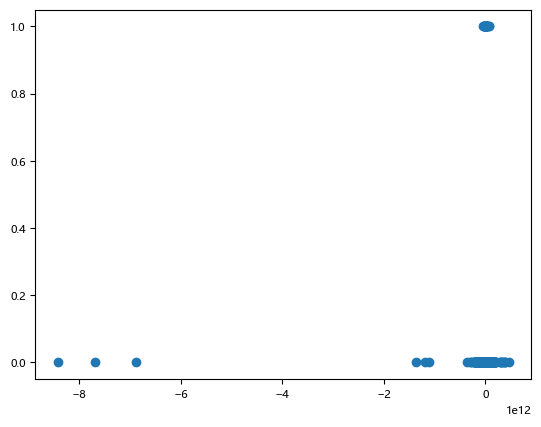

In [741]:
plt.scatter(X_train["营运资金"],y_train)

In [700]:
def evaluate_model(model, X, y_set):
    y_pred_proba = model.predict(X)

    # 計算 ROC 曲線和 AUC
    fpr, tpr, thresholds = roc_curve(y_set, y_pred_proba)
    auc_score = auc(fpr, tpr)
    # 尋找最佳闕值
    J = tpr - fpr
    ix = np.argmax(J)
    best_threshold = thresholds[ix]
    print("* best_threshold: {:.4f}".format(best_threshold))

    y_pred = (y_pred_proba > best_threshold).astype(int)  # <==門檻值
    confusion = confusion_matrix(y_set, y_pred)
    confusion = pd.DataFrame(confusion, columns=[0,1], index=[0,1])
    accuracy = accuracy_score(y_set, y_pred)
    precision = precision_score(y_set, y_pred)
    recall = recall_score(y_set, y_pred)
    f1 = f1_score(y_set, y_pred)

    print("* confusion:\n", confusion)
    print("* accuracy: {:.4f}".format(accuracy))
    print("* precision: {:.4f}".format(precision))
    print("* recall: {:.4f}".format(recall))
    print("* f1-score: {:.4f}".format(f1))

    # ROC 曲線
    plt.figure(figsize=(3, 2))
    plt.plot(fpr, tpr)
    plt.xlabel("FPR (False Positive Rate)")
    plt.ylabel("TPR (True Positive Rate)")
    plt.title("ROC curve")
    print("* AUR area: {:.4f}".format(auc_score))
    plt.show()

* best_threshold: 0.0169
* confusion:
       0    1
0  4368  886
1     8   58
* accuracy: 0.8320
* precision: 0.0614
* recall: 0.8788
* f1-score: 0.1149
* AUR area: 0.9127


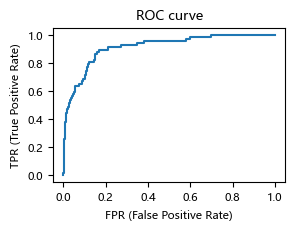

In [701]:
# model3 模型評估 train
evaluate_model(model3, X_train3, y_train)

* best_threshold: 0.0300
* confusion:
       0    1
0  2060  192
1     9   19
* accuracy: 0.9118
* precision: 0.0900
* recall: 0.6786
* f1-score: 0.1590
* AUR area: 0.8427


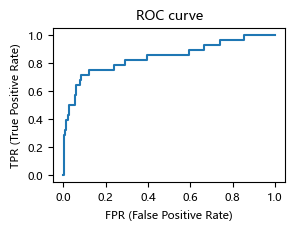

In [702]:
# model3 模型評估 test
evaluate_model(model3, X_test3, y_test)

## 4.4 Model 4

In [703]:
X_train4 = X_train[significant_col].drop(["isType1","isType2","资产减值损失/营业总收入","净资产收益率","regcap_level"],axis=1) #,""
X_test4 = X_test[significant_col].drop(["isType1","isType2","资产减值损失/营业总收入","净资产收益率","regcap_level"],axis=1) #,""
X_train4.head(2)

,销售净利率,财务费用/营业总收入,营业总成本/营业总收入,归属于母公司的股东权益/负债合计,归属于母公司的股东权益/带息债务,...,全部投入资本,营运资金,有形资产,isType3,newindustry
2266,18.2181,-0.5990,81.7781,0.1869,0.5287,...,202763026753.9900,93578358744.6500,52840889988.9700,0,0
1337,23.3040,17.7183,119.3809,0.8787,0.9724,...,19441040425.1400,16444341776.1200,9385485158.1000,1,0


In [704]:
model4 = sm.Logit(y_train, X_train4).fit() 
print("AIC: ", model4.aic)
model4.summary()

Optimization terminated successfully.
         Current function value: 0.047304
         Iterations 12
AIC:  533.3133742141534


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              isDefault   No. Observations:                 5320
Model:                          Logit   Df Residuals:                     5305
Method:                           MLE   Df Model:                           14
Date:                Wed, 15 Nov 2023   Pseudo R-squ.:                  0.2917
Time:                        10:59:21   Log-Likelihood:                -251.66
converged:                       True   LL-Null:                       -355.30
Covariance Type:            nonrobust   LLR p-value:                 1.776e-36
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
销售净利率               -0.0181      0.003     -5.624      0.000      -0.024      -0.012
财务费用/营业总收入           0.0115      0.008      1.371      0.170      -0.005       0.028
营业总成本/营业总收入         -0.0173      0.003     -5.296      0.000      -0.024      -0.011
归属于母公司的股东权益/负债合计     2.1247      0.808      2.630      0.009       0.541       3.708
归属于母公司的股东权益/带息债务    -1.3517      0.484     -2.792      0.005      -2.301      -0.403
存货周转天数              -0.0006      0.000     -3.508      0.000      -0.001      -0.000
应收账款周转天数            -0.0024      0.001     -2.436      0.015      -0.004      -0.000
货币资金／流动负债           -5.8647      1.256     -4.669      0.000      -8.326      -3.403
营业收入同比增长率(%)        -0.0247      0.006     -3.894      0.000      -0.037      -0.012
利息费用              5.689e-10   1.57e-10      3.635      0.000    2.62e-10    8.76e-10
全部投入资本           -1.869e-11   5.34e-12     -3.498      0.000   -2.92e-11   -8.22e-12
营运资金              2.432e-11   8.81e-12      2.760      0.006    7.05e-12    4.16e-11
有形资产             -1.253e-11   5.48e-12     -2.285      0.022   -2.33e-11   -1.78e-12
isType3             -1.4155      0.489     -2.892      0.004      -2.375      -0.456
newindustry          0.7416      0.490      1.513      0.130      -0.219       1.702
====================================================================================

Possibly complete quasi-separation: A fraction 0.21 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

* best_threshold: 0.0158
* confusion:
       0    1
0  4312  942
1     9   57
* accuracy: 0.8212
* precision: 0.0571
* recall: 0.8636
* f1-score: 0.1070
* AUR area: 0.9095


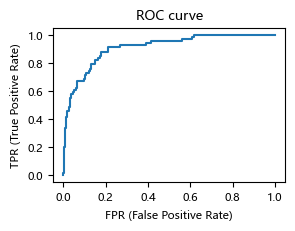

In [705]:
# model4 模型評估 train
evaluate_model(model4, X_train4, y_train)

* best_threshold: 0.0284
* confusion:
       0    1
0  2036  216
1     9   19
* accuracy: 0.9013
* precision: 0.0809
* recall: 0.6786
* f1-score: 0.1445
* AUR area: 0.8450


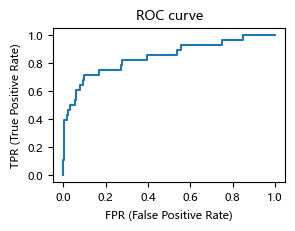

In [706]:
# model4 模型評估 test
evaluate_model(model4, X_test4, y_test)

# **5. 模型評估**
初赛评价指标：AUC

复赛评价指标：本次任务采用精确率F1值（F1-measure, F1）、（Precision, P）、召回率（Recall, R）来评估发债企业违约预测的效果。
精确率为在被所有预测为正的样本中实际为正样本的概率。召回率为在实际为正的样本中被预测为正样本的概率。

F1值计算如下：f1 = 2*P*R / (P + R)

# **6. ML**

In [ ]:
def evaluate_model(model, X_test, y_test, X_train, y_train):
    # 預測目標值
    y_pred = model.predict(X_test)

    # 準確度
    accuracy = accuracy_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("* train score: {:.5f}".format( model.score(X_train, y_train) ))
    print("* test score: {:.5f}".format( model.score(X_test, y_test) ))
    print("* test accuracy：{:.5f}".format( accuracy ))

    # 混淆矩陣
    cm = confusion_matrix(y_test, y_pred)
    print("* 混淆矩陣: \n", cm)

    # 評分表
    cr = classification_report(y_test, y_pred)
    print("* 評分表: 精確度（Precision）、召回率（Recall）、f1-score、support \n", cr)

    # ROC 曲線和AUC
    if hasattr(model, "predict_proba"):
      print("predict_proba")
      y_scores = model.predict_proba(X_test)[:, 1]  # 預測概率
    elif hasattr(model, "decision_function"):
      print("decision_function")
      y_scores = model.decision_function(X_test)  # 決策函數的輸出
    else:
      raise ValueError("模型不支援 predict_proba 或 decision_function 方法")
    
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    auc_score = auc(fpr, tpr)
    print("* AUR area: {:.4f}".format(auc_score))
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.4f})'.format(auc_score))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR (False Positive Rate)')
    plt.ylabel('TPR (True Positive Rate)')
    plt.title('ROC curve')
    plt.legend(loc='lower right')

    # KS 值 (Kolmogorov-Smirnov Statistic)
    ks_statistic, _ = ks_2samp(y_scores[y_test == 1], y_scores[y_test == 0])
    print("* KS value (Kolmogorov-Smirnov Statistic): {:.4f}".format(ks_statistic))

    plt.subplot(1, 2, 2)
    xx = (1 + np.array(range(tpr.size))) / tpr.size
    ks = tpr - fpr
    plt.plot(xx, ks, label="KS")
    plt.plot(xx, tpr, label="tpr")
    plt.plot(xx, fpr, label="fpr")
    plt.title('Kolmogorov-Smirnov Statistic')
    plt.legend(loc='lower right')

    plt.show()

In [ ]:
model_LR = LogisticRegression(C=0.5, class_weight="balanced", solver="sag")
model_LR.fit(X_train, y_train)
evaluate_model(model_LR, X_test, y_test, X_train, y_train)